##Abbreviation Disambiguation for MeDAL Dataset

Nima Shafiei Rezvane Nezhad

The purpose of this project is given a text (in the medical domain), with at least one abbreviation in it, the model should be able to predict what are the full terms of the abbreviations. It is important to know that one abbreviation may have different meanings based on the context.

1. Importing the required libraries from huggingface Transformers.

In [ ]:
!pip install datasets evaluate transformers
!pip install evaluate
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 6.6 MB/s 
     |████████████████████████████████| 81 kB 11.4 MB/s 
     |████████████████████████████████| 5.8 MB 74.3 MB/s 
     |████████████████████████████████| 213 kB 66.0 MB/s 
     |████████████████████████████████| 132 kB 81.3 MB/s 
     |████████████████████████████████| 182 kB 82.5 MB/s 
     |████████████████████████████████| 127 kB 80.1 MB/s 
     |████████████████████████████████| 7.6 MB 61.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Created wheel for seqeva

2. Loading the dataset

MeDAL dataset includes 3 Mn training, 1 Mn validation and 1 Mn test records. Each data containes a text, location of abbreviations in each test, and the full form of abbreviations. In order to be able to use the data for our purpose some preprocessing is required.

- We used a sebset of the whole dataset. (288,000 rows of the whole dataset).
- There are 4,866 unique abbreviations and 16,229 unique labels.
- Due to training and computational complexity, we used the 300 most frequent abbreviations and their 1005 corresponding labels.
- All the punctuations and stopwords can be removed from the dataset.
- Also, for further improvement in using resources, any row with labels that has at least 500 other rows to reference has been removed from the dataset.
- All these steps led to a dataset with 73,196 rows.

Another important part in the processing, is to update the location of abbreviations after removing all the stopwords and punctuations. So the new dataset will include following columns: cleaned text, an updated location of abbreviations, the abbreviations, the labels.

### Token Classification
The approach taken in this project for predicting the full terms of abbreviations is Token classification. In Token classification, like other similar tasks such as POS tagging or Named Entity Recognition, each word in the text, will have a label. If the word is one of the abbreviations, it will have the corresponding label, otherwise, it will be a "NA_word". This will be the label used for the model. This and the corresponding encoding will be added to the columns of our dataset.

In [ ]:
from datasets import load_dataset
ds = load_dataset('parquet', data_files='/content/medal_df_max500v2_for_ner_1005_0726.parquet', split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/default-44f299416bab8981/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


As explained before, the dataset has 73,196 rows that will be split into train, test, and validations.

The columns of the dataset:
- 'TEXT_clean_nostp': The text after removal of punctuations and stopwords
- 'updated_noStp_LOCATION': The updated location of each abbreviation after cleaning the texts
- 'LABEL_final': The labels for each abbreviation
- 'ABV_final': The abbreviations of the text
- 'NER_labels': The encoding of the labels in token classification format
- 'NER_labels_words': The labels in token classification format

In [ ]:
ds

Dataset({
    features: ['TEXT_clean_nostp', 'updated_noStp_LOCATION', 'LABEL_final', 'ABV_final', 'NER_labels', 'NER_labels_words'],
    num_rows: 73196
})

Splitting the dataset into train, test, and validation

In [ ]:
ds = ds.train_test_split(test_size = 0.2)

In [ ]:
ds_test = ds['test']

In [ ]:
ds = ds['train'].train_test_split(test_size = 0.2)

In [ ]:
ds_train = ds['train']
ds_val = ds['test']

As observed, 46,844 rows have been used for training, 11,712 rows for validation. For the test set, according to the memory limitations, we had to use only 1000 rows of the test set.

In [ ]:
ds_train

Dataset({
    features: ['TEXT_clean_nostp', 'updated_noStp_LOCATION', 'LABEL_final', 'ABV_final', 'NER_labels', 'NER_labels_words'],
    num_rows: 46844
})

In [ ]:
ds_val

Dataset({
    features: ['TEXT_clean_nostp', 'updated_noStp_LOCATION', 'LABEL_final', 'ABV_final', 'NER_labels', 'NER_labels_words'],
    num_rows: 11712
})

In [ ]:
ds_test = ds_test.select(range(1000))

In [ ]:
ds_test

Dataset({
    features: ['TEXT_clean_nostp', 'updated_noStp_LOCATION', 'LABEL_final', 'ABV_final', 'NER_labels', 'NER_labels_words'],
    num_rows: 1000
})

How the data in each column looks like:

In [ ]:

ds['train']['TEXT_clean_nostp'][0]

['employing',
 'cytochemical',
 'methods',
 'found',
 'early',
 'embryonic',
 'OD',
 'DM',
 'nuclei',
 'contain',
 'CS',
 'two',
 'kinds',
 'chromosomal',
 'proteins',
 'cleavage',
 'nuclei',
 'also',
 'pronuclei',
 'shortly',
 'blastoderm',
 'stage',
 'contain',
 'atypical',
 'juvenile',
 'histone',
 'stainable',
 'bromophenol',
 'blue',
 'ALP',
 'fast',
 'green',
 'typical',
 'fast',
 'greenpositive',
 'histone',
 'appears',
 'close',
 'period',
 'synchronized',
 'cleavage',
 'mitoses',
 'blastulation',
 'nucleoli',
 'first',
 'produced',
 'amount',
 'dna',
 'antly',
 'less',
 'photopigment',
 'digitonin',
 'solution',
 'pigment',
 'unaffected',
 'sucrose',
 'treatment',
 'pigments',
 'extracted',
 'separated',
 'washed',
 'outer',
 'segments',
 'considered',
 'visual',
 'pigments',
 'dual',
 'system',
 'accounts',
 'spectral',
 'sensitivity',
 'gecko',
 'determined',
 'denton',
 'search',
 'made',
 'evidence',
 'secured',
 'presence',
 'photopigment',
 'absorbing',
 'longer',
 'wave

In [ ]:
ds['train']['updated_noStp_LOCATION'][0]

[6, 7, 10, 29]

In [ ]:
ds['train']['LABEL_final'][0]

['development', 'drosophila melanogaster', 'sequence', 'alkaline']

In [ ]:
ds['train']['ABV_final'][0]

['OD', 'DM', 'CS', 'ALP']

The 30 most frequent Abbreviations in the trainset can be observed.

In [ ]:
l = []
for row in ds_train['ABV_final']:
  for i in row:
    l.append(i)

In [ ]:
from collections import Counter
freq_ABV = sorted(Counter(l).items(), key=lambda item:item[1], reverse = True)[:30]


<BarContainer object of 30 artists>

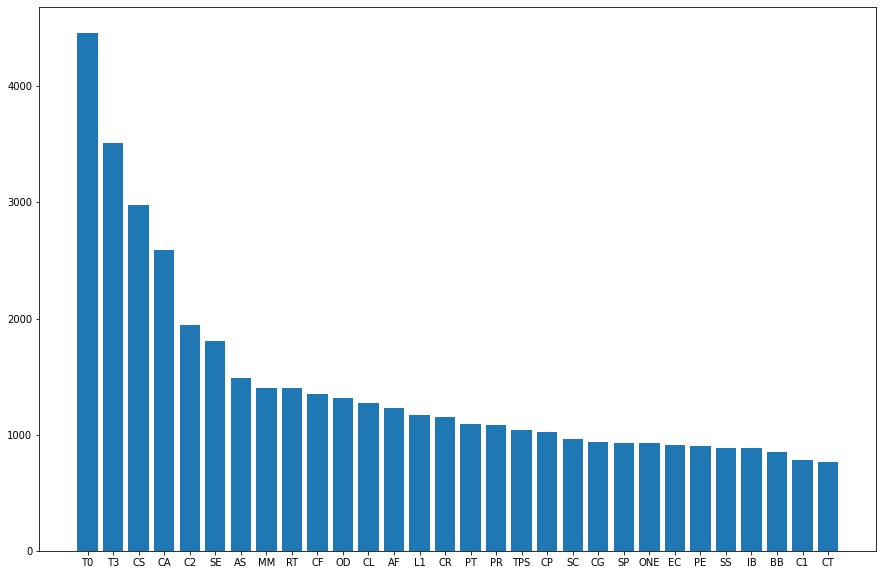

In [ ]:
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure

figure(figsize=(15, 10))

dic = {}
for i in freq_ABV:

  dic[i[0]] = i[1]
# print(dic)
plt.bar(dic.keys(), dic.values())

The unique labels are stored in the label_list variable. It is observed that one of the labels is "NA_word" and it is the last label with index of 1005. This means, each regular word that is not an abbreviation will e labeled with 1005 in label vectors.

In [ ]:
import numpy as np
label_list = np.load('/content/unique_labs_medal_1005.npy', allow_pickle=True)

In [ ]:
'NA_word' in label_list

True

In [ ]:
list(label_list).index('NA_word')

1005

In [ ]:
num_class = len(label_list)
num_class

1006

In [ ]:
label_list[:10]

array(['vesicles', 'alone', 'energy', 'binding', 'electrophysiological',
       'minutes', 'secondary', 'necrosis', 'active', 'alkaline'],
      dtype=object)

We used diffrent models to train the model and compare the results. Some of these models are pretrained on medical dataset and are expected to show better results.
- Scibert: A Pretrained Language Model for Scientific Text
- BioBert: A pretrained Language Model on PubMed abstracts
- BlueBert: A BERT model pre-trained on PubMed abstracts and clinical notes (MIMIC-III)
- DistilBert: was pretrained on the same corpus in a self-supervised fashion, using the BERT base model as a teacher.
- MSBert: MS-BERT was pre-trained on notes from neurological examination for Multiple Sclerosis (MS) patients at St. Michael's Hospital in Toronto, Canada.

In [ ]:
model_checkpoint = 'dmis-lab/biobert-base-cased-v1.2'
# model_checkpoint = 'allenai/scibert_scivocab_uncased'
# model_checkpoint = 'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12'
# model_checkpoint = 'distilbert-base-uncased'
# model_checkpoint = 'NLP4H/ms_bert'

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [ ]:
max_length = 115
def tokenization(ds):


  ds['labels'] = ds['NER_labels']


  ds = tokenizer(ds["TEXT_clean_nostp"],  truncation=True, max_length=max_length, padding = 'max_length', is_split_into_words=True)


  return ds



In [ ]:
tokenized_train = ds_train.map(tokenization, remove_columns=ds_train.column_names)

  0%|          | 0/46844 [00:00<?, ?ex/s]

In [ ]:
tokenized_val = ds_val.map(tokenization, remove_columns=ds_val.column_names)

  0%|          | 0/11712 [00:00<?, ?ex/s]

In [ ]:
tokenized_test = ds_test.map(tokenization, remove_columns=ds_test.column_names)

  0%|          | 0/1000 [00:00<?, ?ex/s]

After tokenization, the columns of dataset becomes 'input_ids', 'token_type_ids', 'attention_mask' and the 'labels' that we just added to it using tokenization function.

In [ ]:
tokenized_train

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 500
})

We initiate the datacollator and the model.

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint,num_labels=num_class)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

We use 4 epochs for training and batch size of 8 due to limitations in memory, but increasing the batch size and increasing the number of epochs will improve the results.

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    "biobert-base-cased-v1.2",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=4,
    weight_decay=0.01,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8

)



PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset= tokenized_val,
    data_collator=data_collator,

    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 46844
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23424
  Number of trainable parameters = 108493294


Epoch,Training Loss,Validation Loss
1,0.197100,0.176752
2,0.157300,0.144065
3,0.138500,0.127584
4,0.128400,0.119475


***** Running Evaluation *****
  Num examples = 11712
  Batch size = 8
Saving model checkpoint to biobert-base-cased-v1.2/checkpoint-5856
Configuration saved in biobert-base-cased-v1.2/checkpoint-5856/config.json
Model weights saved in biobert-base-cased-v1.2/checkpoint-5856/pytorch_model.bin
tokenizer config file saved in biobert-base-cased-v1.2/checkpoint-5856/tokenizer_config.json
Special tokens file saved in biobert-base-cased-v1.2/checkpoint-5856/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 11712
  Batch size = 8
Saving model checkpoint to biobert-base-cased-v1.2/checkpoint-11712
Configuration saved in biobert-base-cased-v1.2/checkpoint-11712/config.json
Model weights saved in biobert-base-cased-v1.2/checkpoint-11712/pytorch_model.bin
tokenizer config file saved in biobert-base-cased-v1.2/checkpoint-11712/tokenizer_config.json
Special tokens file saved in biobert-base-cased-v1.2/checkpoint-11712/special_tokens_map.json
***** Running Evaluation *****
  Nu

TrainOutput(global_step=23424, training_loss=0.16829502859402223, metrics={'train_runtime': 5085.9794, 'train_samples_per_second': 36.842, 'train_steps_per_second': 4.606, 'total_flos': 1.109686272947616e+16, 'train_loss': 0.16829502859402223, 'epoch': 4.0})

To see the result of model prediction on th etest set, we use a function to compute the relevant metrics. In this work, we use f1 score, precision and recall (Macro and average).

In [ ]:
from datasets import load_dataset, load_metric
from seqeval.metrics import f1_score as seq_f1
from seqeval.metrics import precision_score, recall_score, classification_report

def get_AD_performance(predictions, labels):
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100 and l!=1005]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100 and l!=1005]
        for prediction, label in zip(predictions, labels)
    ]
    print(true_labels)
    print(true_predictions)
    f1_actual = np.round(seq_f1(true_labels, true_predictions, average='macro', scheme='token' ) * 100, 2 )
    pre_actual = np.round(precision_score(true_labels, true_predictions, average='macro', scheme='token' ) * 100, 2 )
    rec_actual = np.round(recall_score(true_labels, true_predictions, average='macro', scheme='token' ) * 100, 2 )

    class_report = classification_report(true_labels, true_predictions, output_dict=True )
    f1s = []
    precs = []
    recs = []
    weights = []

    for lab in class_report:
        if lab not in ['micro avg', 'macro avg','weighted avg', 'A_word']:
            f1s.append(class_report[lab]['f1-score'])
            precs.append(class_report[lab]['precision'])
            recs.append(class_report[lab]['recall'])
            weights.append(class_report[lab]['support'])

    return (f1_actual, pre_actual, rec_actual), (np.average(f1s, weights=weights), np.average(precs, weights=weights), np.average(recs, weights=weights))

In [ ]:
predicted, labels, _ = trainer.predict(tokenized_test)
true_predicted= np.argmax(predicted, axis=2)
macro_scores, weighted_scores = get_AD_performance(true_predicted, labels)

***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


[['systemic', 'cardiac surgery'], ['clinical trials', 'functioning', 'function'], ['dementia', 'dementia', 'dementia', 'genotype'], ['nanoparticles', 'nanoparticles', 'nanoparticles'], ['ischemic stroke'], ['quality', 'physical', 'functioning', 'intervention', 'study'], ['transplanted', 'leukocytes', 'leukocytes', 'endothelial', 'leukocytes'], ['study', 'oropharyngeal'], ['mental health'], ['model', 'obstruction'], ['saccharin', 'conditioned', 'adult', 'saccharin', 'exposure', 'element'], ['tyrosine'], ['study', 'intervention', 'development'], ['flow cytometry', 'rheumatoid', 'cord blood', 'b cells'], ['memory', 'eye movement', 'change'], ['white'], ['electrophoresis'], ['symptoms', 'steroids', 'steroids', 'symptoms'], ['identification', 'allele'], ['output'], ['low temperature'], ['precursor'], ['hemodialysis patients', 'heart', 'ischemic stroke', 'artery', 'factors'], ['cadmium'], ['quality', 'twodimensional'], ['neurons', 'central nervous'], ['sensitive', 'electrophoresis'], ['injec

/usr/local/lib/python3.8/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: systemic seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.8/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: cardiac surgery seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.8/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: clinical trials seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.8/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: functioning seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.8/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: function seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.8/dist-packages/seqeval/m

The result of the model on BioBert checkpoint is as below:

In [ ]:
# f1, precision, recall
macro_scores

(33.2, 38.27, 31.86)

In [ ]:
# f1, precision, recall
weighted_scores

(0.5536351085328417, 0.6597341021095372, 0.49813355454168395)

According to the predictions of the model, for the first two instances:
- Labels: ['systemic', 'cardiac surgery'], ['clinical trials', 'functioning', 'function']
- predictions: ['systemic', 'stimulus'], ['clinical trials', 'functioning', 'NA_word']

It is observed that the model is able to learn the labels, but it has yet to be improved. Increasing the number of epochs from 1 to 4 had a great influence on the performance and we believe it would be further improved by increasing the number of epochs.